In [2]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
# Define the file paths for the trajectory and structure
xtc_file = "vars/output_no_water.xtc"
gro_file = "vars/output_no_water.gro"

NUM_RES = 59
NUM_PROTEINS = 30
PROTEIN_LEN = 986
RNA_LEN = 707 # indicates the rna length
NUM_RNA = 30
NUM_RES_RNA = 22 #how many RESIDUES (nucleotide bases) in one rna
rna_start = NUM_PROTEINS * PROTEIN_LEN

u = mda.Universe(gro_file, xtc_file)




/opt/conda/envs/gromacs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


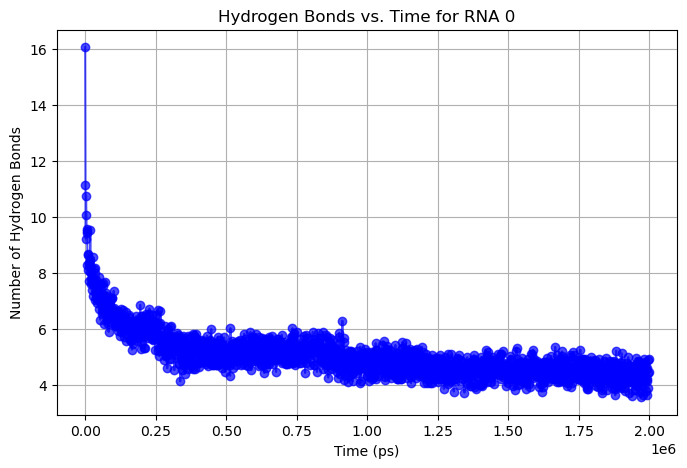

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def count_hbonds_rna(rna_index, average_all=False, HbondType ="GG"):
    if (average_all):
        index_min = rna_start + 1
        index_max = rna_start + RNA_LEN*NUM_RNA
    else:
        index_min = rna_start + rna_index * RNA_LEN + 1
        index_max = rna_start + (rna_index + 1) * RNA_LEN

    # Define atom selections
    # donors_sel = f'(resname GUA CYT and (name N1 N2 N4)) and (bynum {index_min}:{index_max})'
    # hydrogens_sel = f'(resname GUA CYT and (name H1 H21 H22 H41 H42)) and (bynum {index_min}:{index_max})'
    # acceptors_sel = f'(resname GUA CYT and (name O6 N7 O2 N3)) and (bynum {index_min}:{index_max})'
    # donors_sel = f'(resname GUA CYT and (name N1 N2 N4)) and (bynum {index_min}:{index_max})'
    # hydrogens_sel = f'(resname GUA CYT and (name H1 H21 H22 H41 H42)) and (bynum {index_min}:{index_max})'
    # acceptors_sel = f'(resname GUA CYT and (name O6 N7 O2 N3)) and (bynum {index_min}:{index_max})'
    if (HbondType == "GG"):
        donors_sel = f'(resname GUA and (name N1 N2)) and (bynum {index_min}:{index_max})'
        hydrogens_sel = f'(resname GUA and (name H1 H21 H22)) and (bynum {index_min}:{index_max})'
        acceptors_sel = f'(resname GUA and (name N7 O6)) and (bynum {index_min}:{index_max})'
    if (HbondType == "CC"):
        donors_sel = f'(resname CYT and (name N4)) and (bynum {index_min}:{index_max})'
        hydrogens_sel = f'(resname CYT and (name H42 H41)) and (bynum {index_min}:{index_max})'
        acceptors_sel = f'(resname CYT and (name O2 N3)) and (bynum {index_min}:{index_max})'
    if (HbondType == "GC"):
        donors_sel = f'((resname GUA and (name N1 N2)) or (resname CYT and (name N4))) and (bynum {index_min}:{index_max})'
        hydrogens_sel = f'((resname GUA and (name H1 H21 H22)) or (resname CYT and (name H42 H41))) and (bynum {index_min}:{index_max})'
        acceptors_sel = f'((resname GUA and (name O6 N3 N7)) or (resname CYT and (name O2 N3))) and (bynum {index_min}:{index_max})'

    # Initialize the hydrogen bond analysis
    hbonds = HBA(
        universe=u,
        donors_sel=donors_sel,
        hydrogens_sel=hydrogens_sel,
        acceptors_sel=acceptors_sel,
    )
    # Run the analysis
    hbonds.run(start=0, stop=2000)

    # Get hydrogen bond counts per timestep
    if (average_all):
        hbond_counts = hbonds.count_by_time() / NUM_RNA
    else:
        hbond_counts = hbonds.count_by_time()
    time_steps = hbonds.times  # Get time steps

    # Plot hydrogen bond count vs frame/time
    plt.figure(figsize=(8, 5))
    plt.plot(time_steps, hbond_counts, marker='o', linestyle='-', color='b', alpha=0.7)
    plt.xlabel('Time (ps)')
    plt.ylabel('Number of Hydrogen Bonds')
    plt.title(f'Hydrogen Bonds vs. Time for RNA {rna_index}')
    plt.grid(True)
    plt.show()

count_hbonds_rna(0, average_all=True, HbondType="GC")

/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 37358:38064), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 37358:38064).
  warnings.warn(
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 32409:33115), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 32409:33115).
  warnings.warn(
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 35944:36650), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 35944:36650).
  warnings.warn(
/opt/conda/en

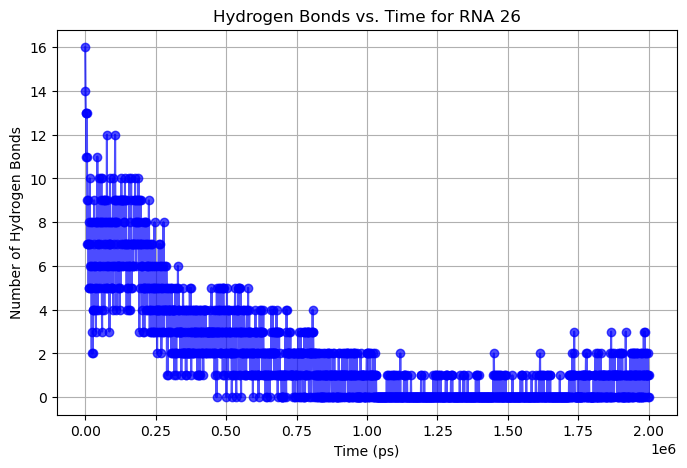

/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 42307:43013), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 42307:43013).
  warnings.warn(


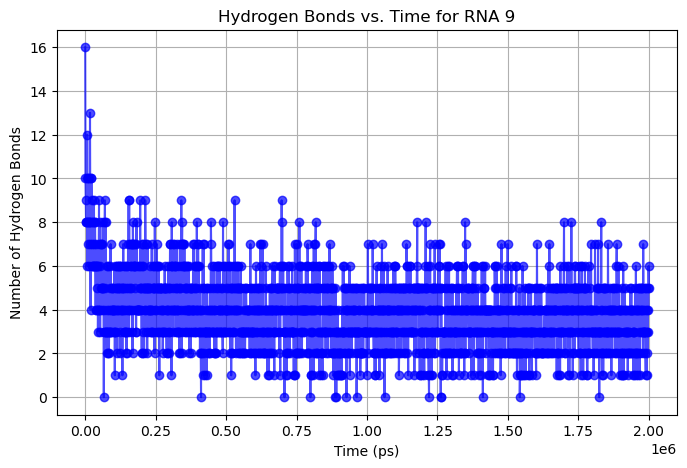

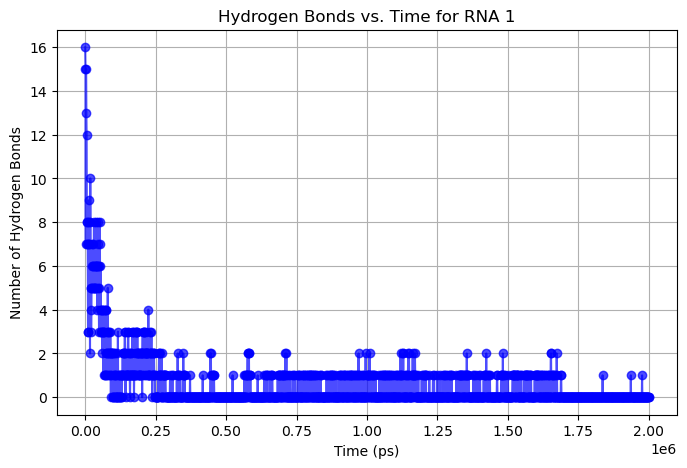

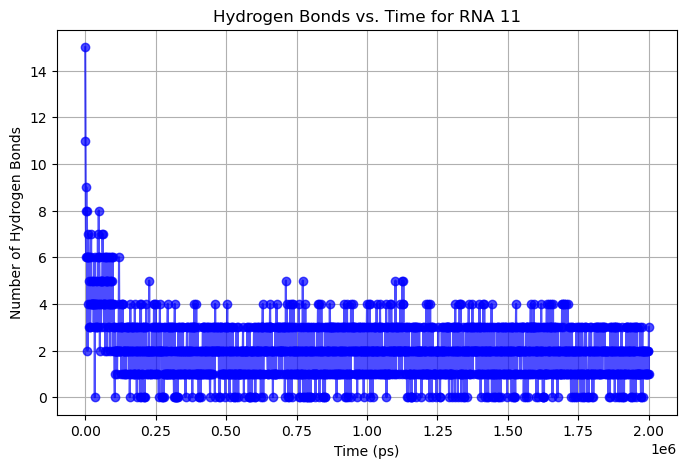

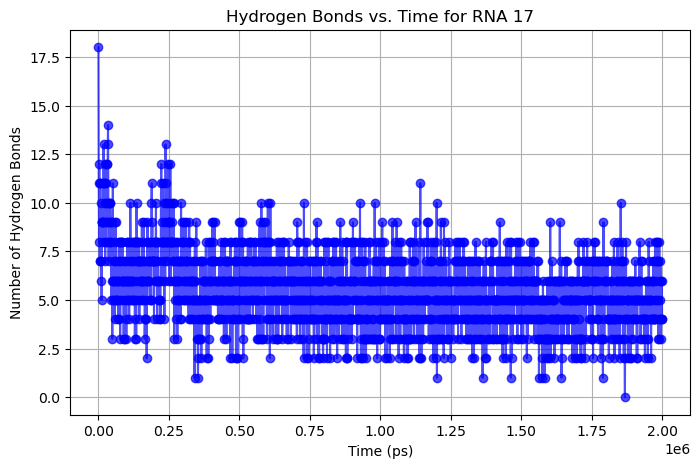

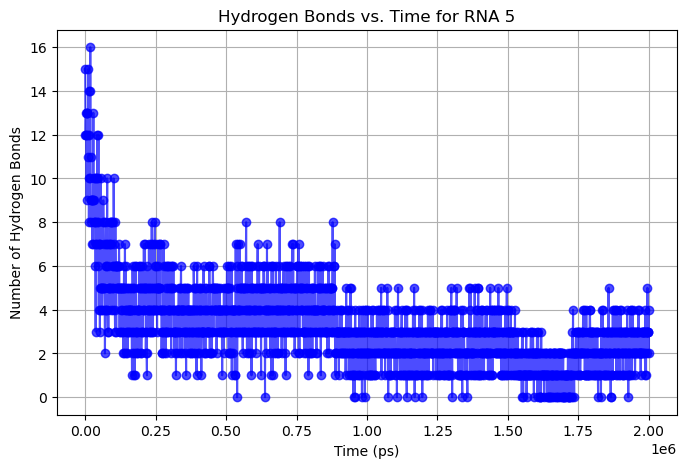

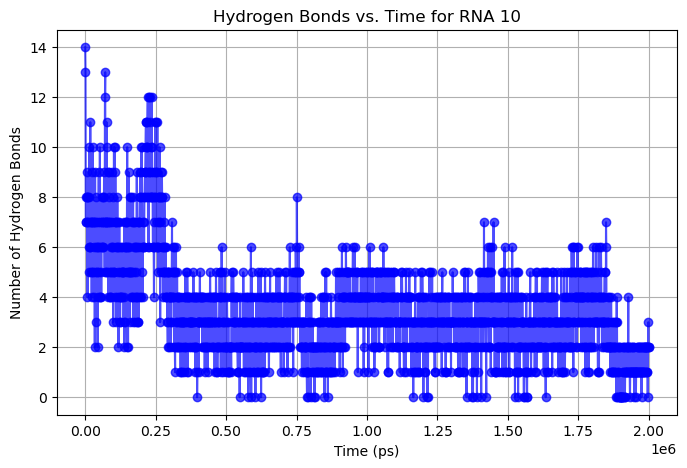

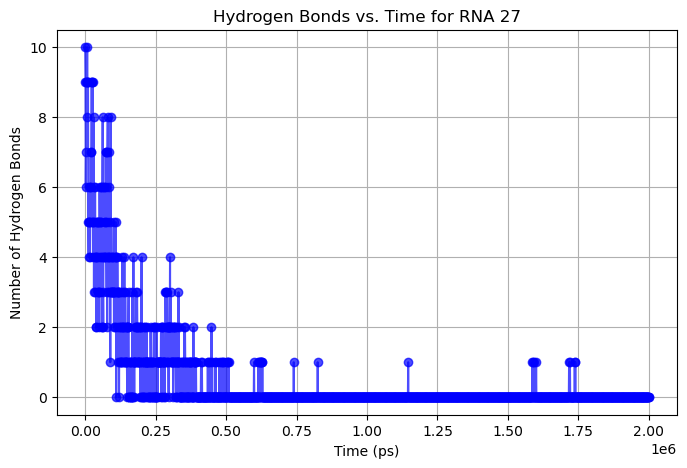

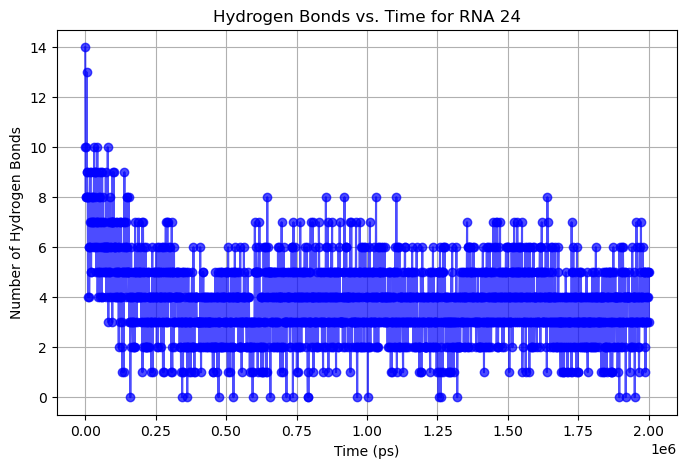

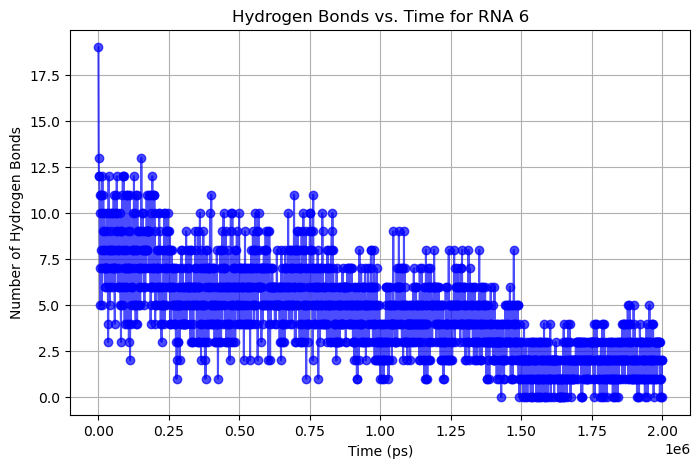

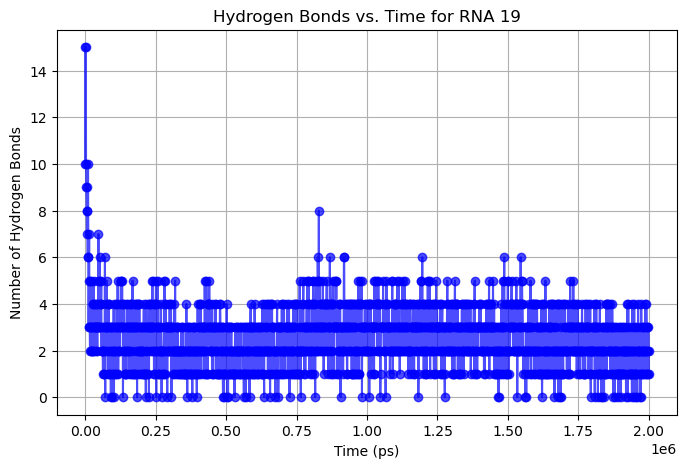

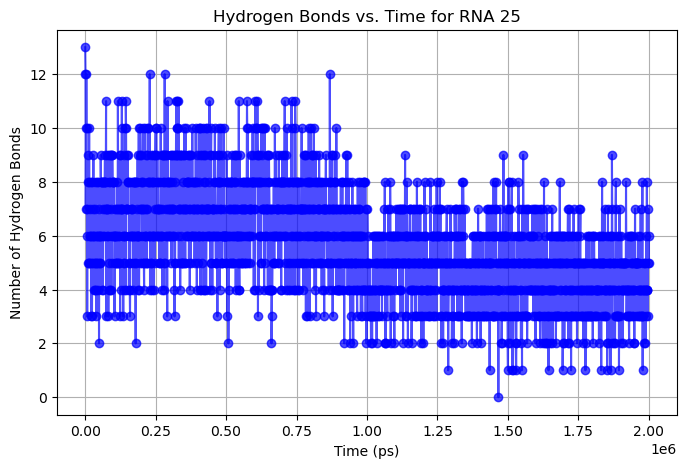

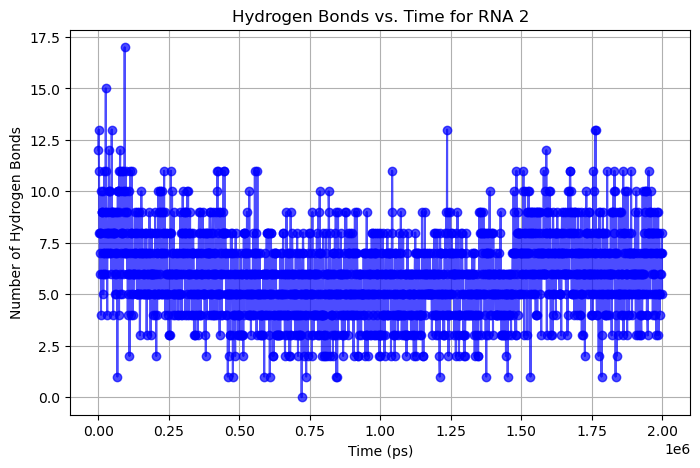

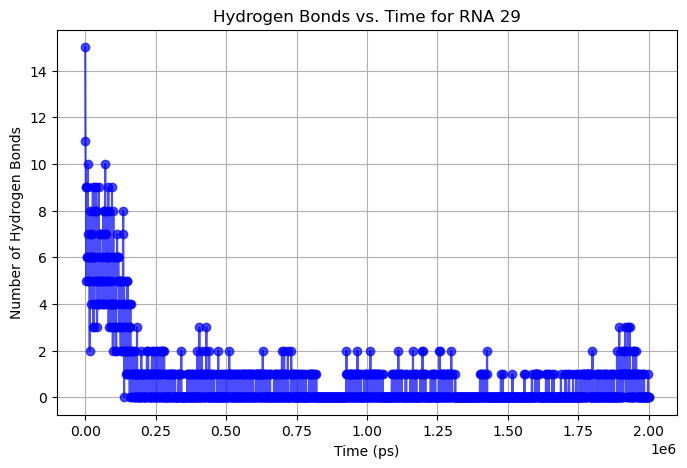

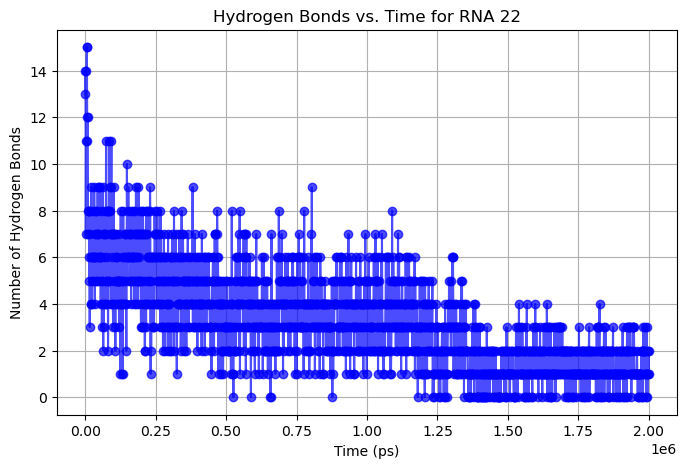

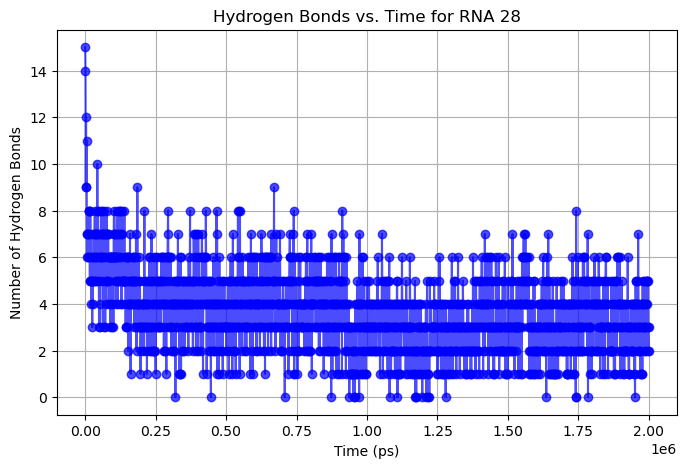

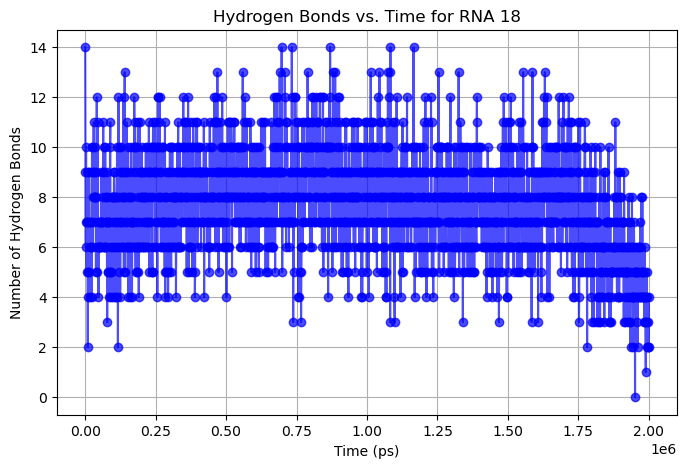

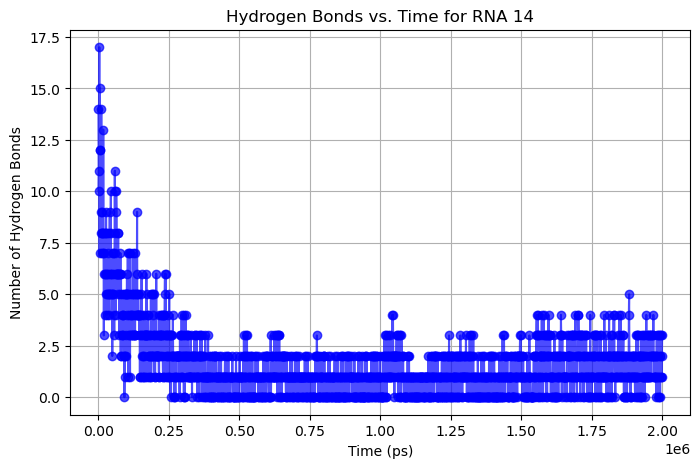

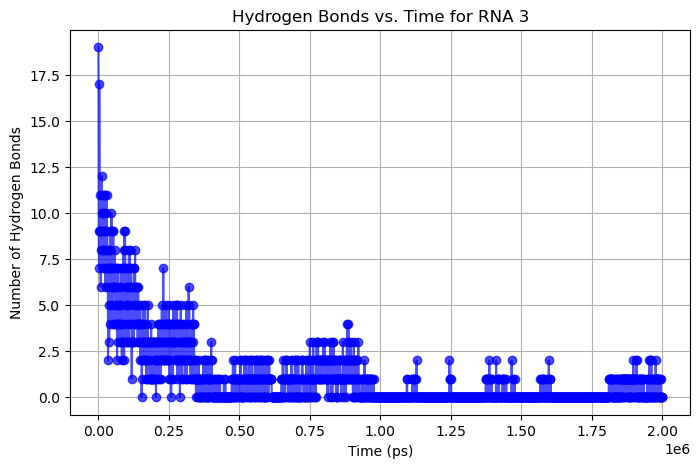

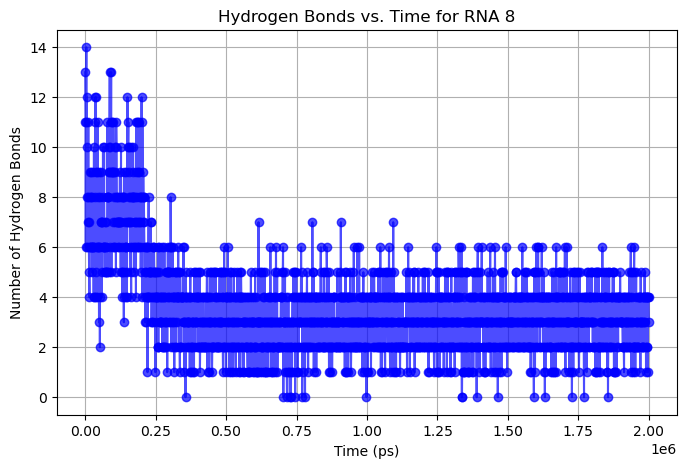

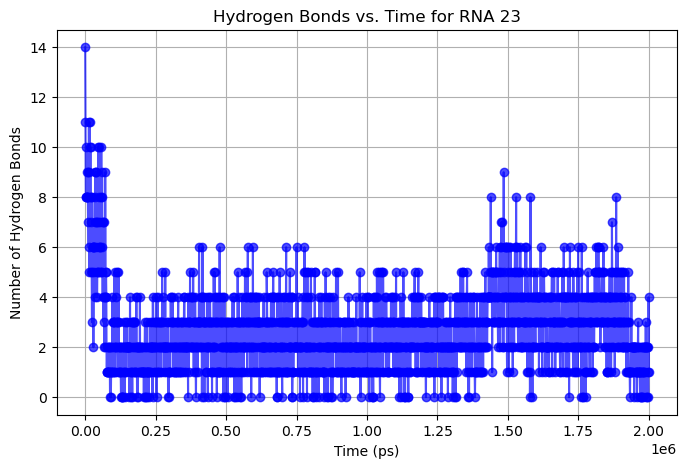

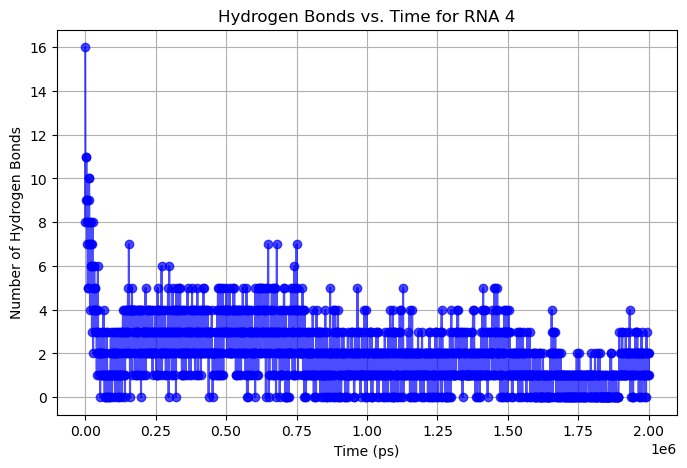

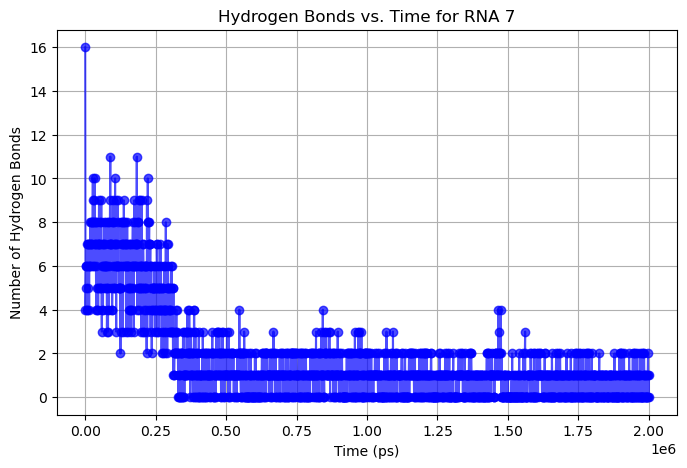

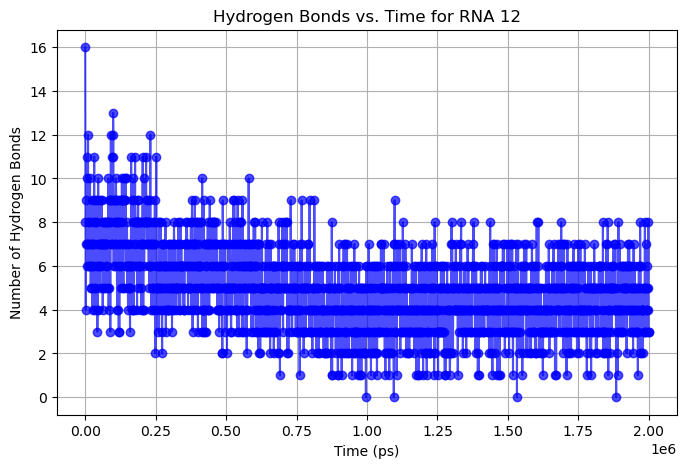

In [21]:
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

def count_hbonds_rna_par(rna_index, gro_file, xtc_file):
    uni = mda.Universe(gro_file, xtc_file) # create its own universe
    index_min = rna_start + rna_index * RNA_LEN + 1
    index_max = rna_start + (rna_index + 1) * RNA_LEN
    donors_sel = f'(resname GUA and (name N1 N2)) and (bynum {index_min}:{index_max})'
    hydrogens_sel = f'(resname GUA and (name H1 H21 H22)) and (bynum {index_min}:{index_max})'
    acceptors_sel = f'(resname GUA and (name N7 O6)) and (bynum {index_min}:{index_max})'

    # Initialize the hydrogen bond analysis
    hbonds = HBA(
        universe=uni,
        donors_sel=donors_sel,
        hydrogens_sel=hydrogens_sel,
        acceptors_sel=acceptors_sel,
    )
    # Run the analysis
    hbonds.run(start=0, stop=2000)
    hbond_counts = hbonds.count_by_time()
    time_steps = hbonds.times  # Get time steps

    # Plot hydrogen bond count vs frame/time
    plt.figure(figsize=(8, 5))
    plt.plot(time_steps, hbond_counts, marker='o', linestyle='-', color='b', alpha=0.7)
    plt.xlabel('Time (ps)')
    plt.ylabel('Number of Hydrogen Bonds')
    plt.title(f'Hydrogen Bonds vs. Time for RNA {rna_index}')
    plt.grid(True)
    plt.show()
    
    # or return something more useful
    return 1

with ProcessPoolExecutor(max_workers=32) as executor:
    futures = []
    ress = 0
    for i in range(NUM_RNA):
        futures.append(executor.submit(count_hbonds_rna_par, i, gro_file, xtc_file))
    
    for future in concurrent.futures.as_completed(futures):
        ress = ress + future.result()